In [1]:
from pyspark.context import SparkContext
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import pandas as pd
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from sklearn.cluster import KMeans
%matplotlib inline

In [2]:
def getAggregatedDfCount(df, columnName, columnAlias):
    return df.groupBy(columnName).agg(F.size(F.collect_list(columnName))).select(col(columnName).alias(columnAlias), col("size(collect_list(" + columnName + "))").alias("count"))

def analyzeContinuousValueColumn(df, columnName, columnAlias, recordName):
    print("Analyze " +  columnName + " column")
    aggregated_df = getAggregatedDfCount(df, columnName, columnAlias)
    pandas_df = aggregated_df.toPandas()
    pandas_df[columnAlias].astype('str')
    pandas_df[columnAlias] = pd.to_numeric(pandas_df[columnAlias], errors='coerce').fillna(0).astype(str)

    print("\ntop 10 " + columnAlias + "s with maximum number of " + recordName + "s:")
    aggregated_df.orderBy("count", ascending=False).show(10)

    print("\n10 " + columnAlias + "s with minimum number of " + recordName + "s:")
    aggregated_df.orderBy("count").show(10)

    pandas_df.plot.hist(grid=True, bins=100, rwidth=1, color='#607c8e')
    plt.title('Products reviews')
    plt.xlabel("#" + recordName + "s")
    plt.ylabel(columnAlias + "s")
    plt.title("Histogram of number of " + recordName + "s per " + columnAlias)
    plt.grid(axis='y', alpha=0.75)
    
def analyzeDescreteValueColumn(df, columnName, columnAlias, recordName):
    print("Analyze " + columnName + " column")
    aggregated_df = getAggregatedDfCount(df, columnName, columnAlias)
    pandas_df = aggregated_df.toPandas()
    pandas_df.sort_values(by=[columnAlias], inplace=True)
    pandas_df[columnAlias].astype('int')
    pandas_df[columnAlias] = pd.to_numeric(pandas_df[columnAlias], errors='coerce').fillna(0).astype(int)
    display(pandas_df.nlargest(5,columns=columnAlias))
    pandas_df.plot(kind='bar',x=columnAlias,y='count')

In [3]:
print("------")
print("Task1:")
print("------")

print("Load the data")
reviews = sc.textFile("Reviews.csv")
header = reviews.first() #extract header
reviews = reviews.filter(lambda row: row != header)   #filter out header

print("Get columns titles")
columnsTitles = header.split(",")

print("Get number of columns, based on columns titles length")
numOfColumns = len(columnsTitles)

print("Filter out corrupted records, with invalid number of columns")
reviews = reviews.filter(lambda p: len(p.split(",")) == numOfColumns)

print("Task1 - done")

------
Task1:
------
Load the data
Get columns titles
Get number of columns, based on columns titles length
Filter out corrupted records, with invalid number of columns
Task1 - done


In [4]:
print("------")
print("Task2:")
print("------")
print("Transform the data set into RDD pair, where the key is the unique id and the value is a Python list which contains the rest of the columns")
transformed_reviews = reviews.map(lambda x:(x.split(",")[0],x.split(",")[1:])) 

print("Task2 - done")

------
Task2:
------
Transform the data set into RDD pair, where the key is the unique id and the value is a Python list which contains the rest of the columns
Task2 - done


In [5]:
print("------")
print("Task3:")
print("------")

print("Choose 5 important columns and for each column, execute tasks a-c\n")

# Define dinctionary of 5 selected columns and their matching index in reviews rdd
selectedColumnsDict = {'ProductId':1, 'UserId':2, 'HelpfulnessNumerator':4, 'HelpfulnessDenominator':5, 'Score':6}

# Define dinctionary of 5 selected columns and their matching aliases, for visualization purposes.
selectedColumnsTitleDict = {'ProductId':'product', 'UserId':'user', 'HelpfulnessNumerator':'helpfulness numerator', 'HelpfulnessDenominator':'helpfulness denominator', 'Score':'score'}

# Extract keys from selectedColumnsDict
selectedColumns = list(selectedColumnsDict)

print("Task3.a")
print("-------")
print("Count the distinct values in each column\n")
columnCountRddList = []

for column in selectedColumns:
    # Extract rdd pair of current column and the suitable count in reviews rdd. 
    columnCountRdd = reviews.map(lambda x:(x.split(",")[selectedColumnsDict[column]],1)).reduceByKey(lambda x, y: x+y)   
    
    # Add current rdd pair to list of rdd pairs.
    columnCountRddList.append(columnCountRdd)
    
    print("number of " + selectedColumnsTitleDict[column] + "s: " + repr(columnCountRdd.count()))

------
Task3:
------
Choose 5 important columns and for each column, execute tasks a-c

Task3.a
-------
Count the distinct values in each column

number of scores: 5
number of users: 84966
number of helpfulness denominators: 87
number of helpfulness numerators: 77
number of products: 40630



Task3.b
-------

get reviews rdd
get reviews data frame
Analyze the slected columns:

Analyze Score column


,score,count
1,5,106054
3,4,16691
0,3,7309
4,2,5928
2,1,13406


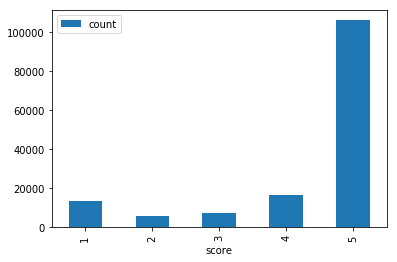

In [6]:
print("\nTask3.b")
print("-------\n")
print("get reviews rdd")
reviews_rdd = reviews.map(lambda line: line.split(","))

print("get reviews data frame")
reviews_df = reviews_rdd.toDF(columnsTitles)

print("Analyze the slected columns:\n")
analyzeDescreteValueColumn(reviews_df, 'Score', 'score', 'review')

Analyze ProductId column

top 10 products with maximum number of reviews:
+----------+-----+
|   product|count|
+----------+-----+
|B007JFMH8M|  401|
|B0026RQTGE|  234|
|B002QWP89S|  234|
|B002QWP8H0|  234|
|B002QWHJOU|  234|
|B005K4Q4LK|  215|
|B005K4Q34S|  215|
|B005K4Q1YA|  215|
|B005K4Q37A|  215|
|B000UBD88A|  171|
+----------+-----+
only showing top 10 rows


10 products with minimum number of reviews:
+----------+-----+
|   product|count|
+----------+-----+
|B000FRZBXE|    1|
|B000NTZ3IW|    1|
|B000HDMUKS|    1|
|B0001UQWRY|    1|
|B000ILMQLM|    1|
|B0006MU99E|    1|
|B000JSO2AM|    1|
|B000E5C59U|    1|
|B000KHVHG4|    1|
|B000FA157W|    1|
+----------+-----+
only showing top 10 rows



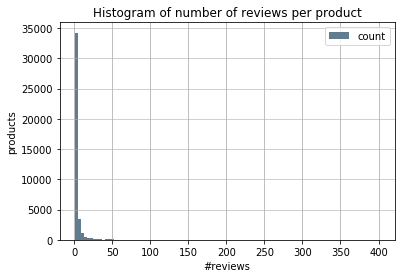

In [7]:
analyzeContinuousValueColumn(reviews_df, 'ProductId', 'product', 'review')

Analyze UserId column

top 10 users with maximum number of reviews:
+--------------+-----+
|          user|count|
+--------------+-----+
| AZV26LP92E6WU|  161|
|A281NPSIMI1C2R|   86|
|A2A8KWCE8RKB9T|   82|
|A2GEZJHBV92EVR|   70|
|A31N6KB160O508|   53|
|A35TIC6B8MVKWG|   49|
|A27NTHPTRXB766|   46|
|A3DOPYDOS49I3T|   45|
| ALL9XFM0Q1N4E|   44|
|A1KOCGNDLF2VUR|   44|
+--------------+-----+
only showing top 10 rows


10 users with minimum number of reviews:
+--------------+-----+
|          user|count|
+--------------+-----+
|A13HKKCHHU1P5M|    1|
|A18471UYYU4JGT|    1|
|A14MSVK0CKT8Q1|    1|
|A10BENY3CHUYHC|    1|
|A14XAJMK8UK30T|    1|
|A111Y9QLUBHKNW|    1|
|A15QLSYISLDCZH|    1|
|A128K9PYRN1BYW|    1|
|A15VVGQ28FGHO1|    1|
|A12I9B47D2EBSN|    1|
+--------------+-----+
only showing top 10 rows



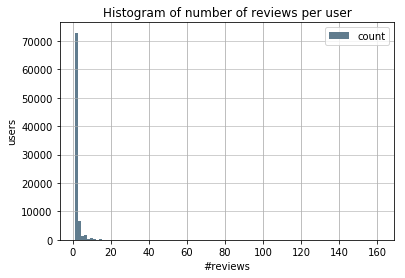

In [8]:
analyzeContinuousValueColumn(reviews_df, 'UserId', 'user', 'review')

Analyze HelpfulnessNumerator column

top 10 helpfulnessNumerators with maximum number of reviews:
+--------------------+-----+
|helpfulnessNumerator|count|
+--------------------+-----+
|                   0|88594|
|                   1|30261|
|                   2|12690|
|                   3| 6404|
|                   4| 3487|
|                   5| 2116|
|                   6| 1445|
|                   7|  953|
|                   8|  661|
|                   9|  547|
+--------------------+-----+
only showing top 10 rows


10 helpfulnessNumerators with minimum number of reviews:
+--------------------+-----+
|helpfulnessNumerator|count|
+--------------------+-----+
|                  58|    1|
|                  77|    1|
|                 193|    1|
|                 274|    1|
|                 466|    1|
|                  64|    1|
|                  55|    1|
|                  71|    1|
|                 446|    1|
|                  54|    1|
+--------------------+-----+
only s

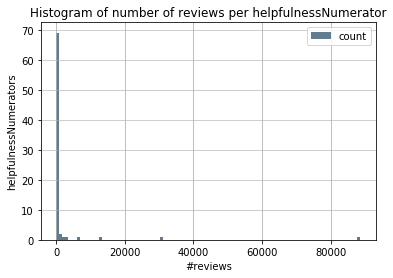

In [9]:
analyzeContinuousValueColumn(reviews_df, 'HelpfulnessNumerator', 'helpfulnessNumerator', 'review')

Analyze HelpfulnessDenominator column

top 10 helpfulnessDenominators with maximum number of reviews:
+----------------------+-----+
|helpfulnessDenominator|count|
+----------------------+-----+
|                     0|79295|
|                     1|29392|
|                     2|15217|
|                     3| 7898|
|                     4| 4941|
|                     5| 2914|
|                     6| 2281|
|                     7| 1538|
|                     8| 1011|
|                     9|  862|
+----------------------+-----+
only showing top 10 rows


10 helpfulnessDenominators with minimum number of reviews:
+----------------------+-----+
|helpfulnessDenominator|count|
+----------------------+-----+
|                    90|    1|
|                    60|    1|
|                   452|    1|
|                    61|    1|
|                   284|    1|
|                   155|    1|
|                   488|    1|
|                    69|    1|
|                    54|    1|
|     

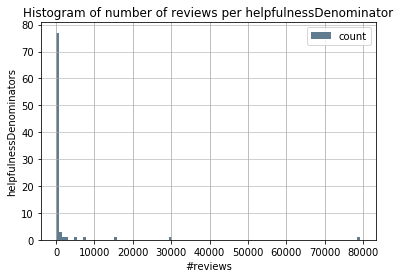

In [10]:
analyzeContinuousValueColumn(reviews_df, 'HelpfulnessDenominator', 'helpfulnessDenominator', 'review')

In [11]:
print("\nTask3.c")
print("-------\n")
print("Explain the results of previous tasks:\n")
'''

----------------
1. Score column:
----------------
Since this column contains descrete values (1-5), It has been plotted on a bar plot.

There are 5 distinct scores
106054 reviews have been ranked as '5 stars'.
16691 reviews have been ranked as '4 stars'.
7309 reviews have been ranked as '3 stars'.
5928 reviews have been ranked as '2 stars'.
13406 reviews have been ranked as '1 stars'.

Number of filtered records is 149388
Total number of reviews is 106054 + 16691 + 7309 + 5928 + 13406 = 149388
Therefore there are no reviews with  0 stars

-------------------------------------------------------------------------------
2. The columns: ProductId, UserId, HelpfulnessNumerator, HelpfulnessDenominator
-------------------------------------------------------------------------------
Since these columns contains continueous values, It has been plotted on a histogram plot.

for each of these columns.
The frequency has been calculated.

So we get for each product|user|helpfulness numerator|helpfulness denominator, the number of relevant reviews.

    2.1 ProductId column:
    -------------------------

    The most popular product is B007JFMH8M, with 401 reviews.
    The are many unpopular products, For example: B000EMK4JQ has only a single review.

    From the products-reviews histogram we can conclude that most of the products have received less than 50 reviews.

    
    2.2 UserId column:
    ----------------------

    The most popular user is AZV26LP92E6WU, who posted with 161 reviews.
    Most of the users posted only a single review. For example: A13HKKCHHU1P5M has posted only a single review.

    From the users-reviews histogram we can conclude that most of the users have posted only a single review.
    
    2.3 HelpfulnessNumerator column:
    --------------------------------
    88594 reviews, have not been indicated by the users as helpful.
    Just a few of the reviews have been indicated as helpful by many users. For example there is a review that has been indicated as helpful by 466 users.

    From the users-reviews histogram we can conclude that most of the reviews were indicated as not helpful by the users.


    2.4 HelpfulnessDenominator column:
    ----------------------------------
    79295 reviews, have not been indicated by the users as helpful or not helpful.
    Just a few of the reviews have been indicated as helpful or not helpful by many users. For example there is a review that has been indicated by 488 users.

    From the users-reviews histogram we can conclude that most of the reviews were not indicated by the users.

'''


Task3.c
-------

Explain the results of previous tasks:



"\n\n----------------\n1. Score column:\n----------------\nSince this column contains descrete values (1-5), It has been plotted on a bar plot.\n\nThere are 5 distinct scores\n106054 reviews have been ranked as '5 stars'.\n16691 reviews have been ranked as '4 stars'.\n7309 reviews have been ranked as '3 stars'.\n5928 reviews have been ranked as '2 stars'.\n13406 reviews have been ranked as '1 stars'.\n\nNumber of filtered records is 149388\nTotal number of reviews is 106054 + 16691 + 7309 + 5928 + 13406 = 149388\nTherefore there are no reviews with  0 stars\n\n-------------------------------------------------------------------------------\n2. The columns: ProductId, UserId, HelpfulnessNumerator, HelpfulnessDenominator\n-------------------------------------------------------------------------------\nSince these columns contains continueous values, It has been plotted on a histogram plot.\n\nfor each of these columns.\nThe frequency has been calculated.\n\nSo we get for each product|user

In [12]:
print("\nTask4.a")
print("-------\n")
print("Fill in bad or missing values:\n")

numOfRecords = reviews_df.count()
pandas_df = reviews_df.toPandas()
isNullValuesFound=0
for i in range(0,numOfColumns):
    c = np.logical_not(pandas_df.isnull()).sum()[i]
    if c != numOfRecords:
        isNullValuesFound=1

if(isNullValuesFound != 0):
    print("Null values have been detected. Filling the gaps...")
    potentialColumnsForFillinValues = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score']
    for column in potentialColumnsForFillinValues:
        maxValue = columnCountRddList[selectedColumns.index(column)].max(lambda x: x[1])[0]
        reviews_df.withColumn(column,F.when(F.isnull(reviews_df[column]),
                                            repr(maxValue)).otherwise(reviews_df[column]))
    reviews_df.show()
    reviews_rdd = reviews_df.rdd()
else:
    print('Null values were not detected')


Task4.a
-------

Fill in bad or missing values:

Null values were not detected


In [13]:
print("\nTask4.b")
print("-------\n")
print("Explain the strategy for Filling in bad or missing values:\n")
'''
The Filling in bad or missing values strategy:
The minimal impact on a row, will be achived by filling the most common value of a given rdd pair.

For example:
in case of the score column, this is the relevant rdd pair [score -> count]:
5 	106054
4 	16691
3 	7309
2 	5928
1 	13406

We can observe, that the most common value (maximum value) is score 5 (with 106054 records).
Therefore if a score is missing in some record, we need to replace it with the value '5'

This strategy will be applied to all off the selected columns.
'''


Task4.a
-------

Explain the strategy for Filling in bad or missing values:



"\nThe Filling in bad or missing values strategy:\nThe minimal impact on a row, will be achived by filling the most common value of a given rdd pair.\n\nFor example:\nin case of the score column, this is the relevant rdd pair [score -> count]:\n5 \t106054\n4 \t16691\n3 \t7309\n2 \t5928\n1 \t13406\n\nWe can observe, that the most common value (maximum value) is score 5 (with 106054 records).\nTherefore if a score is missing in some record, we need to replace it with the value '5'\n\nThis strategy will be applied to all off the selected columns.\n"

In [101]:
print("\nTask5")
print("-------\n")
print("Transform 2 columns which contains categorical features to numerical values:\n")
print("Since there are no categorical columns, we will consider the columns: HelpfulnessNumerator, HelpfulnessDenominator as categorical, by partition these columns to different ranges.")

# Most of the entries in the data are less than 2
# Therefore 0 will be mapped to 0, and 1 will be mapped to 1
# The rest of the values will be mapped according to their suitable length + 1
def getCategory(x):
    if x < 2:
        return x
    return len(str(x)) + 1

# Create the desired mapping between a category and the corespponding value.
helpfulnessDenominatorRddPair = columnCountRddList[selectedColumns.index('HelpfulnessDenominator')].map(lambda x: (int(x[0]), x[1])).sortBy(lambda x: x[1], ascending= False).map(lambda x: (x[0],getCategory(x[0])))
helpfulnessDenominatorCountMap = helpfulnessDenominatorRddPair.collectAsMap()
helpfulnessNumeratorRddPair = columnCountRddList[selectedColumns.index('HelpfulnessNumerator')].map(lambda x: (int(x[0]), x[1])).sortBy(lambda x: x[1], ascending= False).map(lambda x: (x[0],getCategory(x[0])))
helpfulnessNumeratorCountMap = helpfulnessNumeratorRddPair.collectAsMap()

# Map rdd entries with the transformed categories of the columns: helpfulnessDenominator, helpfulnessNumerator
def mapWithCategories(x):
    return (x[0], x[1], x[2], x[3], helpfulnessDenominatorCountMap[int(x[4])], helpfulnessNumeratorCountMap[int(x[5])], int(x[6]), x[7], x[8], x[9])

# Perfoem rdd mapping of 2 categories for the columns: helpfulnessDenominator, helpfulnessNumerator
reviews_rdd = reviews_rdd.map(lambda x: mapWithCategories(x))

# Show top 3 rows after perdormin the transformations
reviews_rdd.take(3)




Task5
-------

Transform 2 columns which contains categorical features to numerical values:

Since there are no categorical columns, we will consider the columns: HelpfulnessNumerator, HelpfulnessDenominator as categorical, by partition these columns to different ranges.


[('1',
  'B001E4KFG0',
  'A3SGXH7AUHU8GW',
  'delmartian',
  1,
  1,
  5,
  '1303862400',
  'Good Quality Dog Food',
  'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'),
 ('2',
  'B00813GRG4',
  'A1D87F6ZCVE5NK',
  'dll pa',
  0,
  0,
  1,
  '1346976000',
  'Not as Advertised',
  '"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."'),
 ('4',
  'B000UA0QIQ',
  'A395BORC6FGVXV',
  'Karl',
  2,
  2,
  2,
  '1307923200',
  'Cough Medicine',
  'If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The fl